In [1]:
import gym
import numpy as np

import time

In [2]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [3]:
import matplotlib.pyplot as plt

In [4]:
# LaTeX rendering in graphs
from distutils.spawn import find_executable
if find_executable('latex'):
    plt.rc('text', usetex=True)

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
import torch

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import models.rnn as rnns
import models.mlp as mlps
import models.linear as linears
import control.agents as agents
import control.environments as env

In [8]:
import copy

# Setup

## Environment


In [9]:
env_name = 'Taxi-v2'

environment = env.Environment(
    environment=gym.make(env_name), 
    agent=None,
    verbose=True,
    max_steps=200,
    capacity=500,
    representation_method='one_hot_encoding',
)

/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Model

In [10]:
model_linear = linears.Linear(
    input_dimension=environment.get_input_dimension(), 
    n_actions=environment.n_actions,
)

model_mlp = mlps.MLP(
    input_dimension=environment.get_input_dimension(), 
    hidden_dimension=100,
    n_hidden_layers=1,
    n_actions=environment.n_actions,
    dropout=0
)

model_rnn = rnns.RNN(
    input_dimension=environment.get_input_dimension(), 
    hidden_dimension=50,
    n_actions=environment.n_actions,
    dropout=.3,
    truncate=10
)

model_attentive_rnn = rnns.AttentiveRNN(
    input_dimension=environment.get_input_dimension(),
    hidden_dimension=50,
    key_dimension=5,
    n_actions=environment.n_actions,
    dropout=.2,
    horizon=-1,
    truncate=10
)

## Agent

In [12]:
model = model_mlp
#model = model_linear

agent = agents.DQNAgent(
    model=model,
    optimiser=torch.optim.Adam(model.parameters(), lr=3e-4), 
    gamma=.99, 
    temperature=10,
    algorithm='qlearning', 
    n_actions=environment.n_actions,
    terminal_state=environment.max_obs
)

environment.agent = agent

Load an agent:

In [12]:
model.load_state_dict(torch.load('../saved/taxi/mlp/state_dict_saved.pth'))
agent.commit()
print(environment.agent.q(environment.state_representation(479)))

[-107.571175 -106.99925  -105.088844 -107.885025 -115.8059   -113.98003 ]


# Experiment

## Training

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 1/20


100%|###############################################################| 10/10 [00:14<00:00,  1.40s/it]


>> Training return : -458.18


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -160.42, steps : 162.64
Epoch 2/20


100%|###############################################################| 10/10 [00:12<00:00,  1.31s/it]


>> Training return : -455.12
>> Evaluation return : -147.90, steps : 151.20


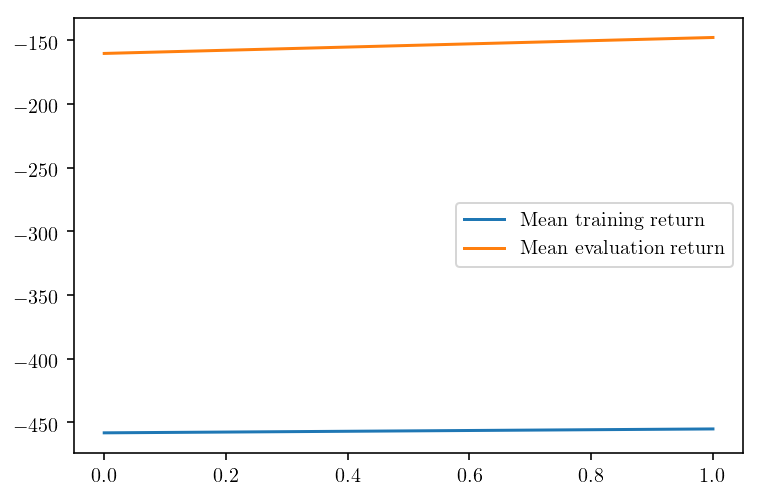

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 3/20


100%|###############################################################| 10/10 [00:12<00:00,  1.21s/it]


>> Training return : -379.52


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -142.10, steps : 147.26
Epoch 4/20


100%|###############################################################| 10/10 [00:11<00:00,  1.15s/it]


>> Training return : -382.12
>> Evaluation return : -159.92, steps : 162.68


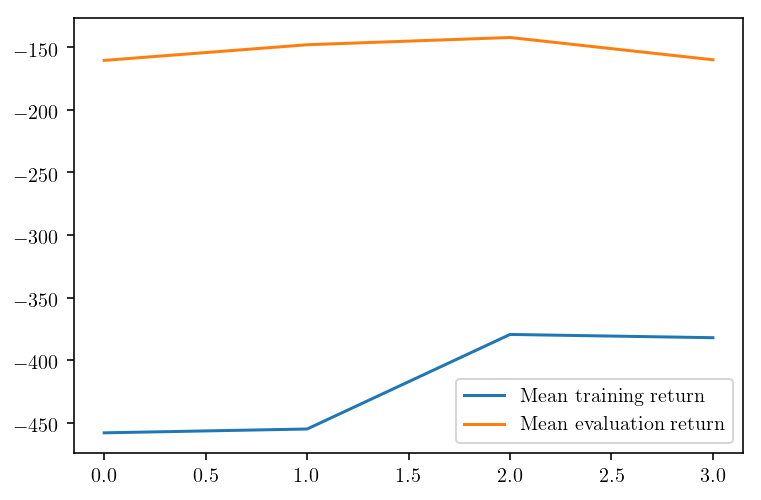

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 5/20


100%|###############################################################| 10/10 [00:11<00:00,  1.19s/it]


>> Training return : -349.53


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -146.66, steps : 151.04
Epoch 6/20


100%|###############################################################| 10/10 [00:11<00:00,  1.17s/it]


>> Training return : -327.91
>> Evaluation return : -184.64, steps : 185.06


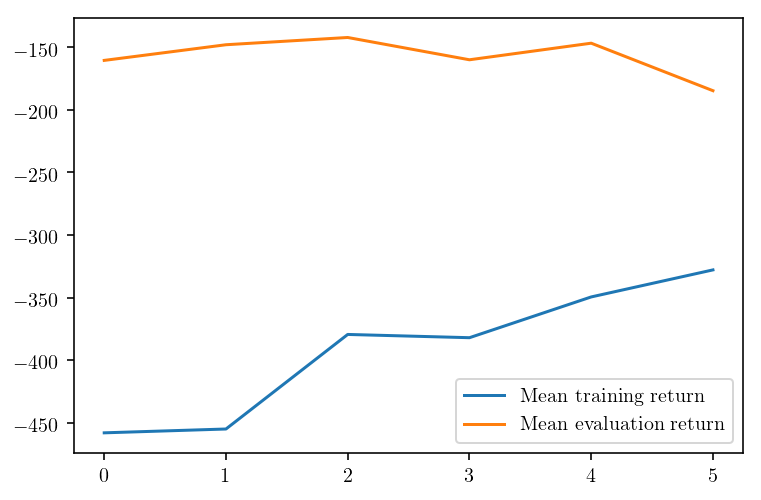

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 7/20


100%|###############################################################| 10/10 [00:11<00:00,  1.15s/it]


>> Training return : -318.00


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -196.38, steps : 196.26
Epoch 8/20


100%|###############################################################| 10/10 [00:11<00:00,  1.18s/it]


>> Training return : -304.71
>> Evaluation return : -175.60, steps : 177.58


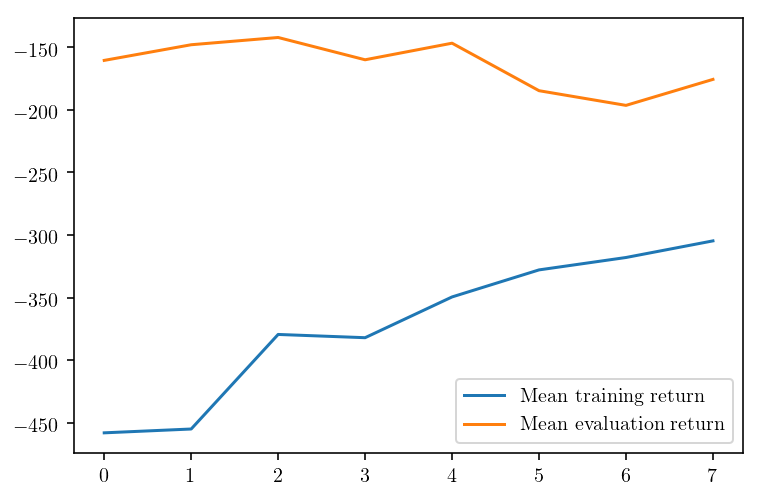

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 9/20


100%|###############################################################| 10/10 [00:12<00:00,  1.32s/it]


>> Training return : -309.62


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -175.22, steps : 177.56
Epoch 10/20


100%|###############################################################| 10/10 [00:12<00:00,  1.28s/it]


>> Training return : -277.86
>> Evaluation return : -200.36, steps : 200.00


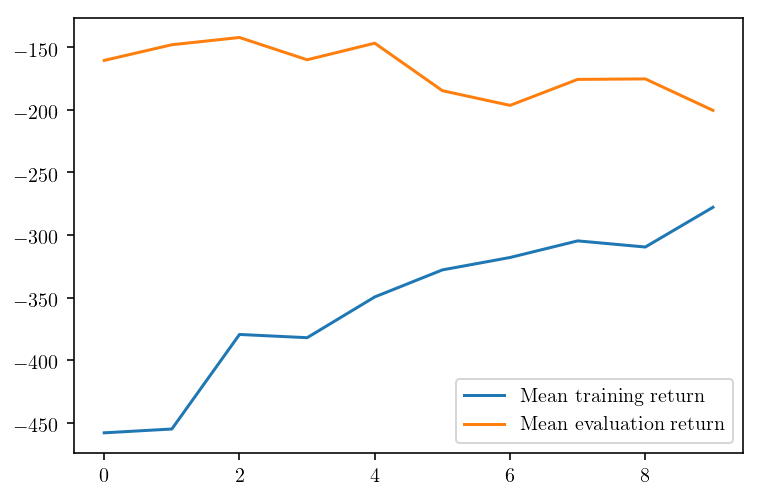

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 11/20


100%|###############################################################| 10/10 [00:14<00:00,  1.50s/it]


>> Training return : -260.05


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -184.42, steps : 185.20
Epoch 12/20


100%|###############################################################| 10/10 [00:15<00:00,  1.51s/it]


>> Training return : -266.96
>> Evaluation return : -184.08, steps : 185.04


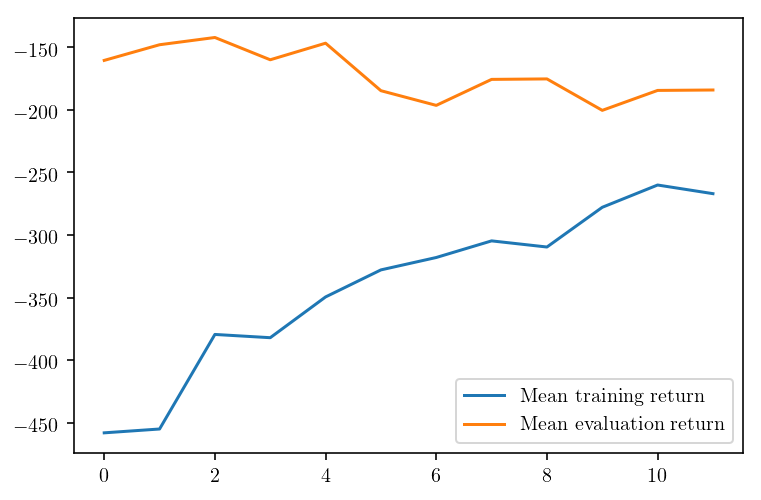

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 13/20


100%|###############################################################| 10/10 [00:15<00:00,  1.57s/it]


>> Training return : -265.78


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -163.54, steps : 166.78
Epoch 14/20


100%|###############################################################| 10/10 [00:16<00:00,  1.74s/it]


>> Training return : -246.94
>> Evaluation return : -134.38, steps : 140.56


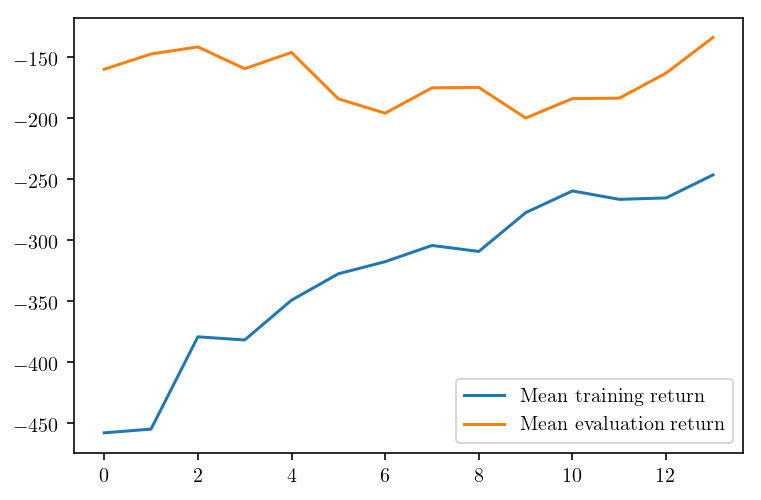

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 15/20


100%|###############################################################| 10/10 [00:18<00:00,  1.93s/it]


>> Training return : -225.75


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -159.34, steps : 162.64
Epoch 16/20


100%|###############################################################| 10/10 [00:16<00:00,  1.59s/it]


>> Training return : -212.05
>> Evaluation return : -155.52, steps : 159.06


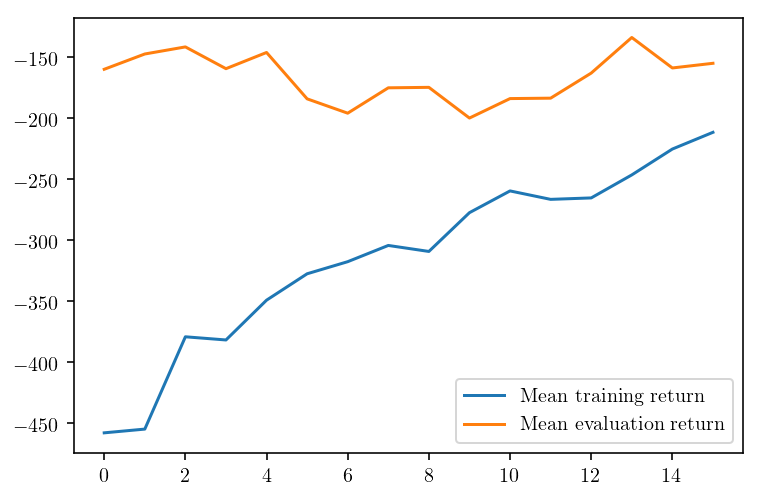

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 17/20


100%|###############################################################| 10/10 [00:16<00:00,  1.60s/it]


>> Training return : -203.94


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -200.00, steps : 200.00
Epoch 18/20


100%|###############################################################| 10/10 [00:16<00:00,  1.59s/it]


>> Training return : -206.36
>> Evaluation return : -150.36, steps : 155.40


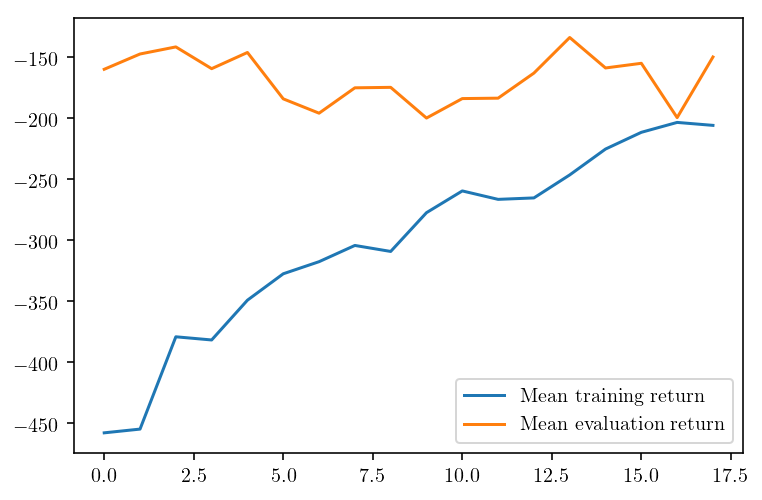

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 19/20


100%|###############################################################| 10/10 [00:15<00:00,  1.56s/it]


>> Training return : -186.77


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -171.42, steps : 174.00
Epoch 20/20


100%|###############################################################| 10/10 [00:15<00:00,  1.61s/it]


>> Training return : -192.32
>> Evaluation return : -171.52, steps : 174.28


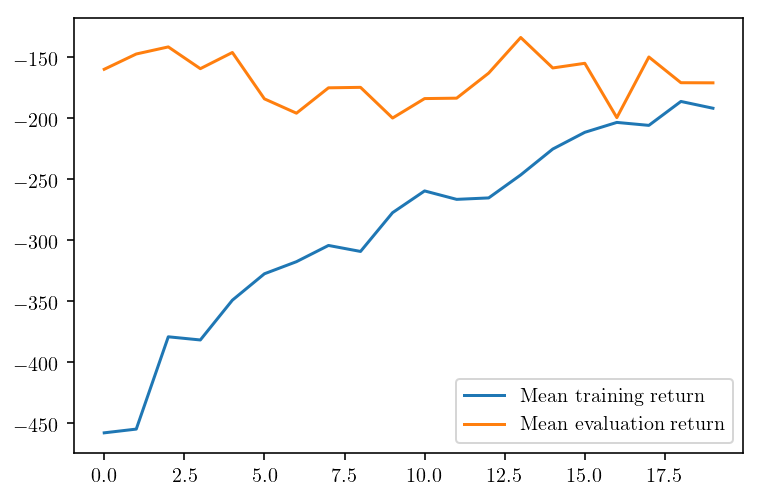

In [14]:
training, evaluation = environment.run(
    epochs=20,
    segments=10,
    episodes=10,
    wall_time=2,
    num_evaluation=50,
    batch_size=100,
    #save_directory='../saved/taxi/mlp',
    #log_directory='taxi_mlp',
    temp_decay = 0.93,
    display_return_curve=True,
)

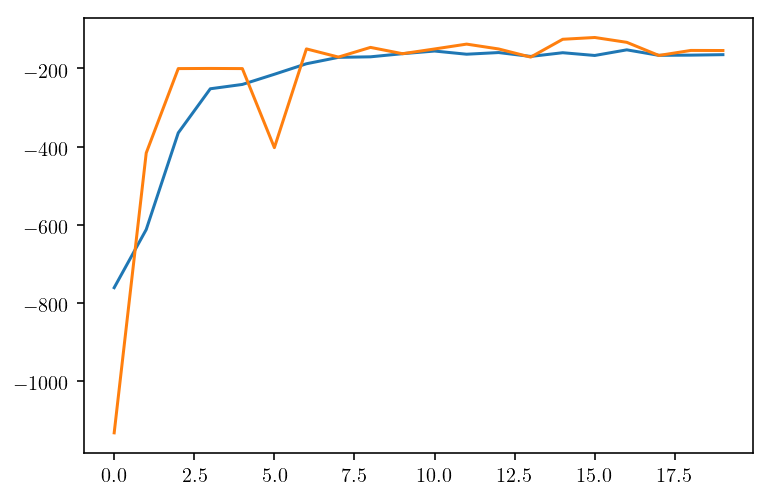

In [13]:
plt.figure()
plt.plot(training)
plt.plot(evaluation)
plt.show()

## Testing

In [14]:
environment.exploration_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

State: 246
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 226
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 126
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
State: 126
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 226
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 206
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 206
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 106
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
State: 106
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| :

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 346
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 326
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
State: 326
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 426
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 426
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
State: 426
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 426
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 326
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
State: 326
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | :

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 486
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 466
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 366
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 366
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 366
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 366
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 466
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 466
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 366
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |


(-452.0, 200)

In [24]:
environment.evaluation_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

State: 294
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 294
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 394
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 494
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 474
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
State: 478
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
State: 378
+---------+
|R: | : :G|
| : : : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 278
+---------+
|R: | : :G|
| : : : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 258
+---------+
|R: | : :G|
| : : : : |
| :_: : : |
| | : | : |
|Y| : 

(8.0, 13)

## Save

In [41]:
environment.agent.save('../saved/taxi/mlp')